In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances
from mpl_toolkits.mplot3d import Axes3D

random_state = 10 # Ensure reproducible results
%matplotlib inline

In [2]:
#------------DATA and TRAIN VALIDATION TEST SPLIT-----------------
#--- load data
ing_mat = loadmat('MATLAB/ingredients.mat')['ingredients']
cityDist_mat = loadmat('MATLAB/citiesDistMat.mat')['citiesDistMat']
labelName_mat = loadmat('MATLAB/labelNames.mat')['labelNames']
labels_mat = loadmat('MATLAB/labels.mat')['labels']
recipe_mat = loadmat('MATLAB/recipes.mat')['recipes']

#--- for colnames
ing_headline = []
for i in ing_mat[0]:
    ing_headline.append(i[0])

#--- create data matrices
dataset_X = pd.DataFrame(recipe_mat,columns=ing_headline) #predictors
dataset_y = pd.DataFrame(labels_mat,columns=['label']) #labels
X_train_full,X_test,y_train_full,y_test = train_test_split(dataset_X,dataset_y,test_size=0.2) #train test split
X_train,X_val,y_train,y_val = train_test_split(X_train_full,y_train_full,test_size=0.25) #train val split
X_train_len = len(X_train)


In [3]:
dataset_y = dataset_y.squeeze()
y_train = y_train.squeeze()

In [4]:
#--- additionally have cuisines as list
cuisines = []
for n in range(0, 12, 1):
    idx = dataset_y.index[dataset_y.values == n+1]
    cuisines.append(labelName_mat[idx[0]][0].item())

# Exploratory Data Analysis

## Plots

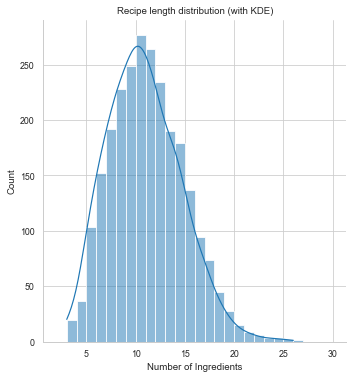

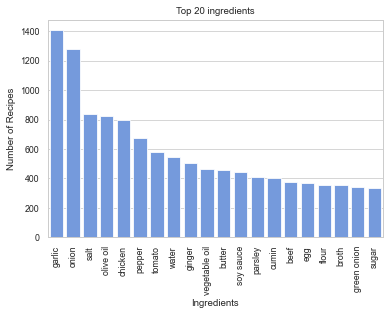

In [5]:
#------------EXPLORATORY DATA ANALYSIS-----------------

## Diagrams
## -- Plot number of ingredients
sns.set_context('paper')
sns.set_style("whitegrid")
ax = sns.displot(np.sum(X_train,axis=1), bins=np.linspace(1,29,29)+1,kde=True)
ax.set(xlabel="Number of Ingredients", title="Recipe length distribution (with KDE)")
# ax.savefig("./Figures/Recipe_length.png", dpi=500) ## Save the figure produced

##--- top 20 most used ingredients
fig, ax = plt.subplots()
# sum up occurences of each ingredient and
# filter for the 20 most frequent
most_freq_ing = X_train.sum().nlargest(20)
ax = sns.barplot(x=most_freq_ing.index, y=most_freq_ing.values, color='cornflowerblue')
ax.set(xlabel="Ingredients", ylabel="Number of Recipes", title="Top 20 ingredients")
xticks = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.figure.savefig("./Figures/Top_20.png", dpi=500) ## Save the figure produced

In [7]:
## 2nd Version of barplot, with vertical orientation
# sns.set_palette(reversed(sns.color_palette("Blues_d", 20)),20)
# sns.barplot(y=most_freq_ing.index,x=most_freq_ing.values)

## Tables

### Number of ingredients per cuisine

In [6]:
## Tables
## number changes due to the randomness of the split...
used_ing = []
for n in range(0, 12, 1):
    idx = y_train.index[y_train.values == n+1] # find number of recipes per label // due to .squeeze() changed from .label to .values
    freq_ing_cuis = X_train.loc[idx].sum() # find ingredients in the recipes per label
    used_idx = freq_ing_cuis.index[freq_ing_cuis != 0] 
    used_ing.append(len(used_idx)) # append total ingredients

data_ing = pd.DataFrame(data = {"Cuisine": cuisines, 
                    "#Ingredients Used": used_ing})

data_ing.sort_values(by="#Ingredients Used", ascending=False)

## might be better to use original dataset as follows:

# used_ing = []
# for n in range(0, 12, 1):
#     idx = dataset_y.index[dataset_y.values == n+1] // due to .squeeze() changed from .label to .values
#     freq_ing_cuis = dataset_X.iloc[idx].sum()
#     used_idx = freq_ing_cuis.index[freq_ing_cuis != 0]
#     used_ing.append(len(used_idx))

# data_ing = pd.DataFrame(data = {"Cuisine": cuisines, 
#                     "#Used ingredients": used_ing})

# data_ing.sort_values(by="#Used ingredients", ascending=False)

,Cuisine,#Ingredients Used
1,English,280
2,French,244
7,Japanese,238
10,Spanish,226
11,Thai,217
8,Mexican,216
9,Moroccan,209
3,German,207
4,Greek,199
5,Indian,199


In [7]:
#--- Average number of ingredients for each cuisine per recipe
av_num_ing = []
for i in range(0, 12, 1):
    idx = dataset_y.index[dataset_y.values == i+1] # // due to .squeeze() changed from .label to .values
    # row-wise sum of ingredients
    sum_ing = dataset_X.iloc[idx].sum(axis=1)
    av_num_ing.append(sum_ing.mean())

data_av_ing = pd.DataFrame(data = {"Cuisine": cuisines, 
                    "Average no. of ingredients": av_num_ing})

data_av_ing.sort_values(by="Average no. of ingredients", ascending=False)

,Cuisine,Average no. of ingredients
9,Moroccan,13.189802
5,Indian,12.832861
11,Thai,11.674221
0,Chinese,11.413598
10,Spanish,11.263456
4,Greek,10.773371
2,French,10.495751
6,Italian,10.373938
8,Mexican,10.232295
3,German,9.532578


# Dimensionality Reduction

### Functions

The following function `scatter_2d_label()` is used to create a 2D scatter plot that also annotates the corresponding classes appropriately.

In [24]:
def scatter_2d_label(X_2d, y, ax=None, s=10, alpha=0.5, lw=5):
    """Visualise a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    ax : matplotlib axes.Axes 
         axes to plot on
         
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    ## custom color palette so that colors do not repeat
    cc = ['#ebac23','#b80058','#008cf9','#006e00','#00bbad','#d163e6','#b24502','#ff9287','#5954d6','#00c6f8','#878500','#00a76c','#bdbdbd']

    targets = np.unique(y)  # extract unique labels
    colors = sns.color_palette(cc,n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        sns.scatterplot(x=X_2d[y == target, 0], y=X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw, ax=ax)
#         ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], color=color, label=target, s=s, alpha=alpha, lw=lw)
    
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3, frameon=False); # Add a legend outside the plot at specified point
    
    return ax

In [9]:
##-----Create Dictionary and y_train labels with strings for plot legends
labelsName = [l[0][0] for l in labelName_mat]
labels_dict = pd.DataFrame(labelsName,columns=['label']) #labels dictionary
label_index = y_train.index
y_train_labels = labels_dict.loc[label_index].squeeze()

## PCA

In [33]:
## PCA

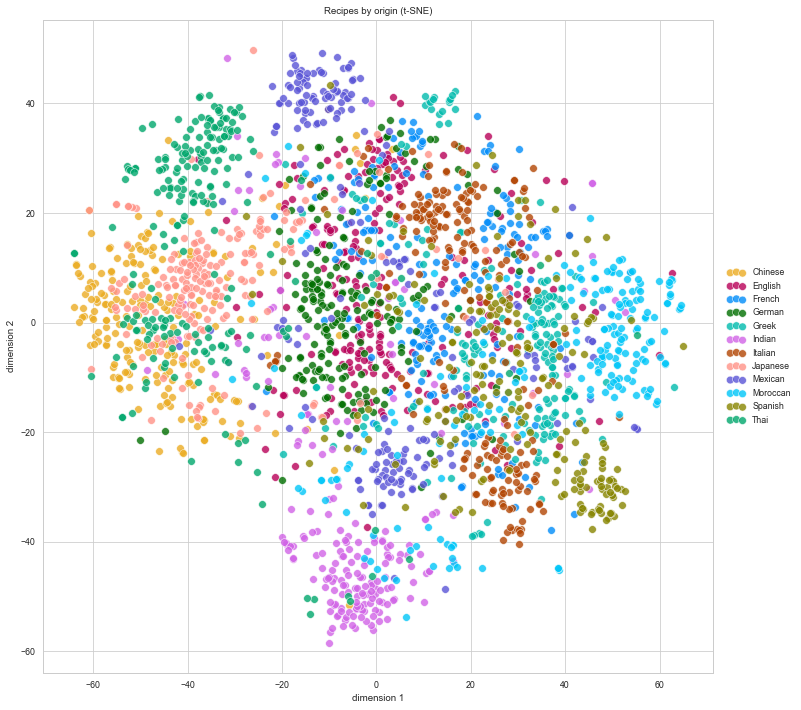

In [34]:
## tSNE
## create low dimensional representasion with TSNE
X_embedded = TSNE(n_components=2,perplexity=30,n_iter=2000,init='pca').fit_transform(X_train)

## ---- Plot the figure
fig, ax = plt.subplots(figsize=(12,12))
scatter_2d_label(X_embedded,y_train_labels,alpha=.8,ax=ax,s=60)
ax.set_xlabel('dimension 1')
ax.set_ylabel('dimension 2')
title = ax.set(title='Recipes by origin (t-SNE)')
# ax.figure.savefig("./Figures/PCA_tSNE.png", dpi=500) ## Save the figure produced

In [ ]:
## ISOMAP


In [ ]:
## UMAP


In [ ]:
#------------MODELS-----------------------------------

## Logistic Regression


## Naive Bayes


## Logistic Regression DR


## Naive Bayes DR


## Other 1


## Other 2


## Other 3

In [ ]:
#------------VALIDATION-------------------------------

## BEST MODEL Hyperparameter tuning

## Final Model



In [ ]:
#------------TEST SET PREDICTIONS---------------------

## Accuracy scores

## MISC

